In [1]:
############### SESYNC Research Support: Urban green planning ########## 
## Processing agricultural crop data by week.
## 
##
## DATE CREATED: 11/08/2018
## DATE MODIFIED: 11/14/2018
## AUTHORS: Benoit Parmentier  
## Version: 1
## PROJECT: Urban green infrastructure planning
## ISSUE: 
## TO DO:
##
## COMMIT: fixed gdal.Warp bug, reprojection to MD SRS
##

###################################################
#

###### Library used

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd


################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

def open_image(url):
    image_data = open_http_query(url)
    
    if not image_data:
            return None
            
    mmap_name = "/vsimem/"+uuid4().get_hex()
    gdal.FileFromMemBuffer(mmap_name, image_data.read())
    gdal_dataset = gdal.Open(mmap_name)
    image = gdal_dataset.GetRasterBand(1).ReadAsArray()
    gdal_dataset = None
    gdal.Unlink(mmap_name)
    
    return image

############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
in_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/GAstart"
#in_dir <- "/nfs/tjovanovic-data/Data/Baltimore/Hydrology/GAstart"
#ARGS 2
out_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/outputs"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 7
out_suffix = "processing_data_11082018" #output suffix for the files and ouptut folder
#ARGS 8
num_cores = 2 # number of cores
file_format = ".tif"

dem_baltimore_filename = "DEM_BaltArea_1m.tif"
lc_baltimore_filename = "landCover_area1m.tif"
reg_outline_filename = "watersheds8digit.shp"

################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir = "output_data_"+out_suffix
    out_dir = os.path.join(in_dir,out_dir)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

directory already exists


,OBJECTID,mde6digt,mde6name,mde8digt,mde8name,weblink,cbi,geometry
0,61,021309,PATAPSCO RIVER,02130905,Gwynns Falls,http://mddnr.chesapeakebay.net/wsprofiles/surf...,2.510101,POLYGON ((-8552481.550799999 4790048.482500002...
1,63,021309,PATAPSCO RIVER,02130904,Jones Falls,http://mddnr.chesapeakebay.net/wsprofiles/surf...,3.021277,POLYGON ((-8526477.726900002 4779313.976200014...
2,68,021309,PATAPSCO RIVER,02130901,Back River,http://mddnr.chesapeakebay.net/wsprofiles/surf...,1.892857,POLYGON ((-8526440.000599997 4779304.909200005...
3,70,021309,PATAPSCO RIVER,02130906,Patapsco River L N Br,http://mddnr.chesapeakebay.net/wsprofiles/surf...,2.561661,POLYGON ((-8560441.437599996 4775324.676700011...
4,73,021309,PATAPSCO RIVER,02130903,Baltimore Harbor,http://mddnr.chesapeakebay.net/wsprofiles/surf...,2.378571,POLYGON ((-8530255.744399998 4764309.857600003...


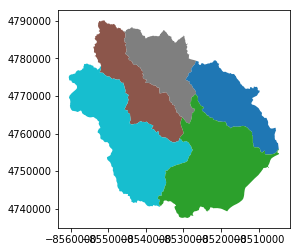

In [2]:
#######################################
### PART 1: Read in DATA #######

dem_baltimore_filename = os.path.join(in_dir,dem_baltimore_filename)
lc_baltimore_filename = os.path.join(in_dir,lc_baltimore_filename)
reg_outline_filename = os.path.join(in_dir,reg_outline_filename)

reg_gpd = gpd.read_file(reg_outline_filename)
reg_gpd.describe()
reg_gpd.plot(column="mde8name")
reg_gpd.head() 


In [5]:
#########################################
### PART 2: Crop to region of interest #######
#Open existing raster ds
dem_baltimore = rasterio.open(os.path.join(in_dir,dem_baltimore_filename))
reg_dem_gpd = reg_gpd.to_crs(dem_baltimore.crs)

extent_val = reg_dem_gpd.total_bounds #minx,MINY,MAXX,MAXY
#Need a gdal object
dem_baltimore = gdal.Open(os.path.join(in_dir,dem_baltimore_filename))

#gdal.WarpOptions()
gdal.Warp("cropped_dem.tif",dem_baltimore,outputBounds=extent_val)
dem_baltimore= None

lc_baltimore = rasterio.open(os.path.join(in_dir,lc_baltimore_filename))

reg_lc_gpd = reg_gpd.to_crs(lc_baltimore.crs)

extent_val = reg_lc_gpd.total_bounds #minx,MINY,MAXX,MAXY
lc_baltimore = gdal.Open(os.path.join(in_dir,lc_baltimore_filename))

gdal.Warp("cropped_lc.tif",lc_baltimore,outputBounds=extent_val)
lc_baltimore= None

In [14]:
#########################
### PART 3: reproject raster to Maryland State plane #######

#https://gis.stackexchange.com/questions/257257/how-to-use-gdal-warp-cutline-option/257292
#https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#get-raster-metadata

#local md projection:
crs_reg = "+proj=lcc +lat_1=39.45 +lat_2=38.3 +lat_0=37.66666666666666 +lon_0=-77 +x_0=400000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs" 

#gdal.WarpOptions()
dem_cropped_baltimore = gdal.Open(os.path.join(out_dir,"cropped_dem.tif"))
gdal.Warp("dem_md.tif", dem_cropped_baltimore,dstSRS=crs_reg)
dem_cropped_baltimore = None


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f7361f5a240> >